In [1]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.colors import LogNorm
import numpy as np
import pandas as pd
from scipy import stats
from scipy.interpolate import griddata
from scipy.interpolate import interp1d
import os
import seaborn as sns
import awkward as awk

sns.set_style('whitegrid')

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial", "DejaVu Sans", "Helvetica", "sans-serif"],
    "mathtext.fontset": "dejavusans",
    'font.size': 16,
    'image.cmap': 'YlGnBu',
})

n_m, n_U = 30, 20
m_sample = np.geomspace(2e-2, 4e-1, n_m)
U_sample = np.geomspace(1e-7, 1e-2, n_U)
m_sample, U_sample = np.meshgrid(m_sample, U_sample)
m_sample = m_sample.flatten()
U_sample = U_sample.flatten()

POT = {}
bkg = {}

# POT 
POT['ND280_nu_2013'] = 1.52E20 
POT['ND280_nubar_2013'] = 1.52E20

# POT in Abe et al 2019
POT['ND280_nu_2019'] = 1.234e21
POT['ND280_nubar_2019'] = 6.29e20

POT['ND280_nu_2023'] = 19.7e20
POT['ND280_nubar_2023'] = 16.3e20

# POT Events conducted in ND280+
# 1E22 is cumulative
POT['ND280+_nu'] = 5e21 - POT['ND280_nu_2019'] 
POT['ND280+_nubar'] = 5e21 - POT['ND280_nubar_2019']


# TPC e+e- background from Abe et al 2019
bkg['ND280_nu_2019'] = 0.563
bkg['ND280_nubar_2019'] = 0.015

bkg['ND280+_nu'] = bkg['ND280_nu_2019'] * 5 / 3 * POT['ND280+_nu'] / POT['ND280_nu_2019']  # Factor of 5/3 from increase of TPC volume from 3 -> 5
bkg['ND280+_nubar'] = bkg['ND280_nubar_2019']* 5 / 3 * POT['ND280+_nubar'] / POT['ND280_nu_2019'] 

bkg['ND280_nu_2023'] = bkg['ND280_nu_2019']  * POT['ND280_nu_2023'] / POT['ND280_nu_2019'] 
bkg['ND280_nubar_2023'] = bkg['ND280_nubar_2019'] * POT['ND280_nubar_2023'] / POT['ND280_nu_2019'] 

bkg['ND280_nu_2013'] = bkg['ND280_nubar_2019'] * POT['ND280_nu_2013'] / POT['ND280_nu_2019'] 
bkg['ND280_nubar_2013'] = bkg['ND280_nubar_2019'] * POT['ND280_nubar_2013'] / POT['ND280_nu_2019'] 
bkg['zero'] = 0


In [19]:
# Constants
HBAR = 6.582119569e-25  # Reduced Planck constant (GeV·s)
C = 2.998e8  # Speed of light (m/s)
HBAR_C = HBAR * C  # (GeV·m)
Gf = 1.1663787e-5 # (GeV^-2)
alpha = 1/137
mass = {}
mass['e'] = 0.511e-3 # Electron mass in GeV
mass['mu'] = 0.1056583755 # Muon mass in GeV

get_min_efficiency = 1/100 # <1% efficiency, optimistic bound
# get_min_efficiency = create_get_min_efficiency_linear_fit()

def gamma_TMM_2body(m, mu):
    return mu**2 * m**3 / (16*np.pi)
    
def gamma_TMM_3body(m, mu, mlep=None):
    if mlep is not None:
        mask = m >= 2*mlep
        result = np.zeros_like(m)
        if np.any(mask):
            m_valid = m[mask]
            r = mlep/m_valid
            L = (2 - r**6 * 0.125) * np.arccosh(1/r) - (24 - 10 * r**2 + r**4) * 0.125 * np.sqrt(1 - 4*r**2)
            result[mask] = alpha * mu**2 * m_valid**3 * L / (48*np.pi**2)
        return result
    else:
        return result

def gamma_Weak(m, U):
    return Gf**2 * m**5 * U**2 / (96*np.pi**3)

def gamma_Total_Decay(m, mu, U):
    return gamma_TMM_2body(m, mu) + gamma_TMM_3body(m,mu,mass['e']) + gamma_TMM_3body(m,mu,mass['mu']) + gamma_Weak(m, U)

def BR(m, mu, U):
    return gamma_TMM_2body(m, mu) / gamma_Total_Decay(m, mu, U)
    
def surviving_prob(E, mN, mu, U, DIF_dist, prob = False):
    survive_decay = np.exp(-DIF_dist * gamma_Total_Decay(mN, mu, U) / ( np.sqrt(((E/mN)**2-1)) * HBAR_C))
    survive_det = 1 - np.exp( - 3*0.56 * gamma_Total_Decay(mN, mu, U) / ( np.sqrt(((E/mN)**2-1)) * HBAR_C) ) if prob else 1
    return survive_decay * survive_det

def rho(u, m):
    a = (mass['mu'] / 0.494)**2 # Muon mass and Kaon mass ratio in GeV
    b = (m / 0.494)**2 # HNL mass and Kaon mass ratio in GeV
    sqkallen = np.sqrt(1 + a**2 + b**2 -2*a - 2*b - 2*a*b) # Kallen function λ(1,a,b)
    return u**2 * ( a + b - ( a - b )**2 ) * sqkallen / (a * (1-a)**2)

def logLR(z, key='ND280+_nu'):

    if key == 'zero':
        return z
    elif key == 'fgd':
        return np.absolute(z - z * 99 * np.log(1 + 1/99)) # signal to bkg fraction ~1%
    else:
        return np.absolute(z - bkg[key] * np.log(1 + z/bkg[key]))
    
# 95% Confidence Level
def tar(cl=0.9):
    return 0.5 * stats.norm.ppf(1-cl)**2

Extract the counts

Plot surviving probabilities

<Figure size 800x600 with 0 Axes>

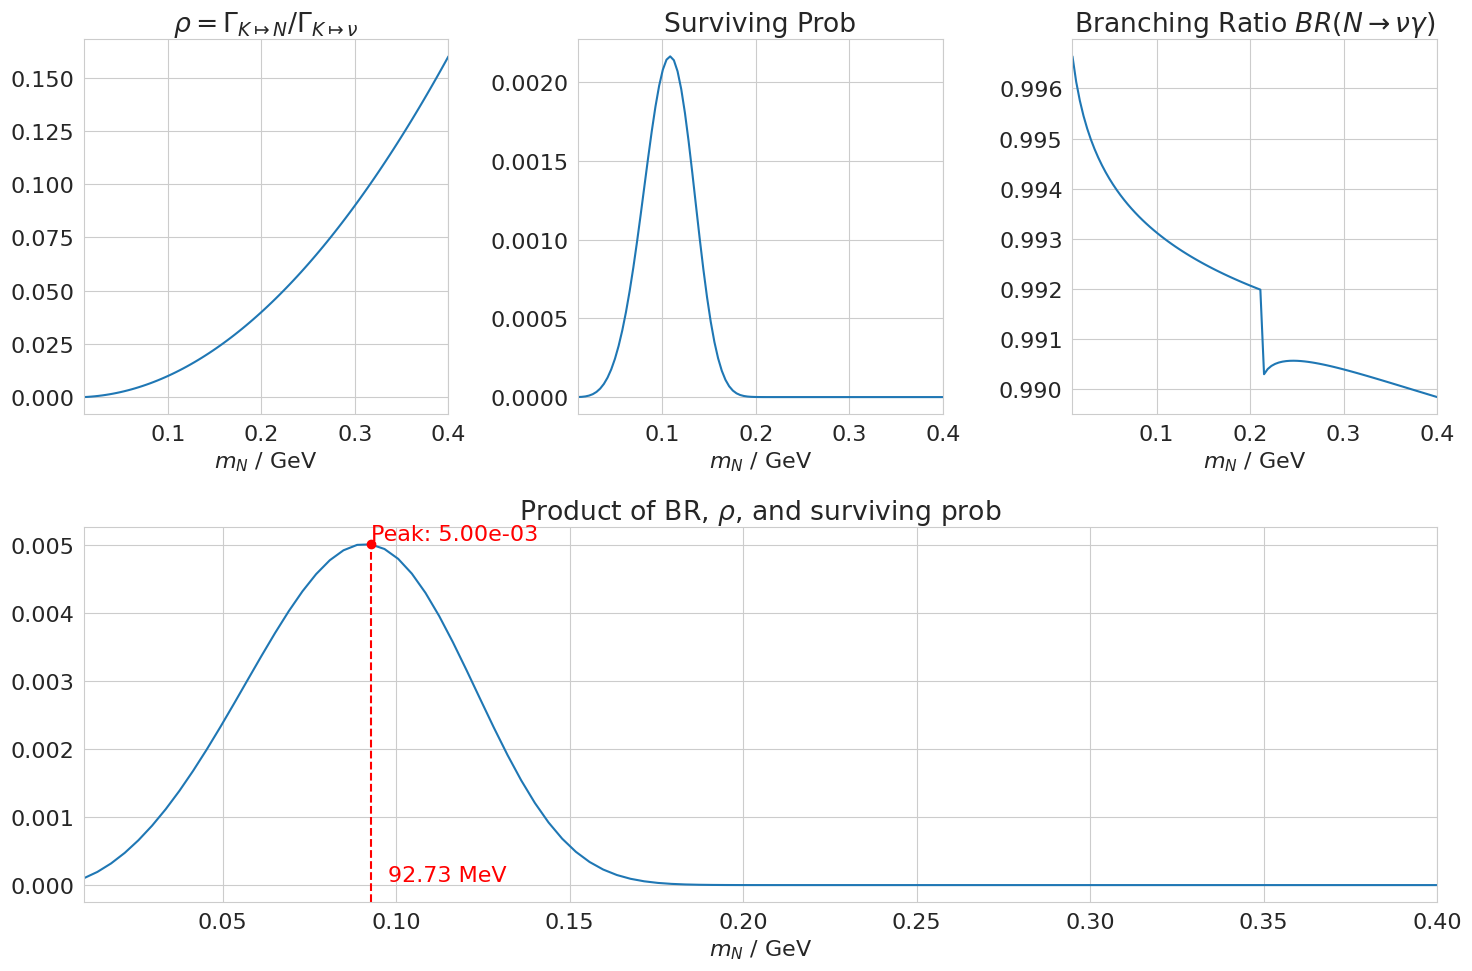

In [31]:
x = np.linspace(0.01, 0.4, 100)

# Using an alternative method without `add_subplot`, utilizing `gridspec` to handle the layout
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(8, 6))
gs = GridSpec(2, 3, figure=fig, height_ratios=[1, 1])

# Highlighting the peak of the final product in the fourth plot

# Calculate the product values again
product_values = BR(x, 1e-6, 1e-4) * rho(x, 1e-4) * surviving_prob(4, x, 1e-6, 1e-4, 284.9)

# Find the peak value and its corresponding x-value
peak_index = np.argmax(product_values)
peak_x = x[peak_index]
peak_value = product_values[peak_index]

# Create the plots again with the peak highlighted
fig = plt.figure(figsize=(15, 10))
gs = GridSpec(2, 3, figure=fig, height_ratios=[1, 1])

# First row: three separate graphs
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(x, rho(x, 1e-4))
ax1.set_xlabel(r'$m_N$ / GeV')
ax1.set_xlim(0.01, 0.4)
ax1.set_title(r'$\rho = \Gamma_{K\mapsto N }/\Gamma_{K\mapsto\nu}$')

ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(x, surviving_prob(4, x, 1e-6, 1e-4, 284.9, prob=True))
ax2.set_xlabel(r'$m_N$ / GeV')
ax2.set_xlim(0.01, 0.4)
ax2.set_title(r'Surviving Prob')

ax3 = fig.add_subplot(gs[0, 2])
ax3.plot(x, BR(x, 1e-6, 1e-4))
ax3.set_xlabel(r'$m_N$ / GeV')
ax3.set_xlim(0.01, 0.4)
ax3.set_title(r'Branching Ratio $BR(N \rightarrow \nu \gamma)$')

# Second row: product of the three values multiplied, spanning all three columns
ax4 = fig.add_subplot(gs[1, :])
ax4.plot(x, product_values)
ax4.set_xlabel(r'$m_N$ / GeV')
ax4.set_xlim(0.01, 0.4)
ax4.set_title(r'Product of BR, $\rho$, and surviving prob')

# Highlight the peak
ax4.plot(peak_x, peak_value, 'ro')  # Highlight the peak with a red dot
ax4.text(peak_x, peak_value, f'Peak: {peak_value:.2e}', color='red', verticalalignment='bottom', horizontalalignment='left')
ax4.axvline(x=peak_x, color='red', linestyle='--', ymax=(peak_value - ax4.get_ylim()[0]) / (ax4.get_ylim()[1] - ax4.get_ylim()[0]))
ax4.text(peak_x+0.005, 0, f'{1000*peak_x:3.2f} MeV', color='red', verticalalignment='bottom', horizontalalignment='left')

plt.tight_layout()
plt.show()

Extract weights from simulation

In [10]:
FGD_boxes = np.array([
    [0, 0, -0.375, 1.843,1.843, 0.288],
    [0, 0, 0.99, 1.843,1.843, 0.288]
]) # TPC dimensions extracted from Matheus' paper

def is_points_in_boxes(points, boxes):
    points = np.asarray(points)
    boxes = np.asarray(boxes)
    centers, dimensions = boxes[:, :3], boxes[:, 3:]
    
    # Broadcasting to compare all points with all boxes
    in_bounds = np.all(
        (points[:, np.newaxis, :] >= centers - dimensions/2) & 
        (points[:, np.newaxis, :] <= centers + dimensions/2),
        axis=2
    )

    # Check if each point is in any box
    return np.any(in_bounds, axis=1)

DIF_dist = 280

def process_data(bar=False, mu=1e-6, tag='prob_1E-6'):
    
    prob = True if 'prob' in tag else False

    outfile = f'./counts_{tag}_bar.txt' if bar else f'./counts_{tag}.txt'

    z = []
    
    with open(outfile, 'w') as f, open('./OGTPC1.txt', 'w') as w:
        for ind, (m, u) in enumerate(zip(m_sample, U_sample)):
            
            path = "OGTPC1_Dipole_M%2.2e_Umu%2.2e_example.parquet" % (m, u)
            
            if prob:
                file_path = f'./output_prob_1E-6_bar/{path}' if bar else f'./output_prob_1E-6/{path}'
            else:
                file_path = f'./output_1E-6_bar/{path}' if bar else f'./output_1E-6/{path}'
                
            if os.path.isfile(file_path):
                try:
                    data = awk.from_parquet(file_path)
                    pts = data['vertex'][:,0]
                    if prob:
                        weight = data['event_weight'] / np.squeeze(data['int_probs']) # back out of detector
                    else:
                        weight = data['event_weight'] * is_points_in_boxes(pts, FGD_boxes) # fid volume cut
                    mask = np.logical_not(np.isnan(weight))
                    scaled_counts = weight * rho(u, m) #* BR_TMMee(m, mu, u)
                    scaled_counts = scaled_counts * surviving_prob(np.squeeze(data['primary_momentum'][:,:,0]),m,mu,u,DIF_dist,prob) 
                    counts = np.sum(scaled_counts[mask]) 
                    counts = counts if counts != 0 else 1e-300 # add padding
                    f.write(f'{m:2.10e} {u:2.10e} {counts:2.10e}\n')
                    
                except Exception as e:
                    # If there's any error reading the file, write the parameters to the file
                    print(f"Error reading file {file_path}: {str(e)}")
                    w.write(f"{ind} {m} {u}\n")
            else:
                w.write(f"{ind} {m} {u}\n")
              
# process_data(bar=False, mu=1e-6, tag='prob_1E-6')
# process_data(bar=True, mu=1e-6, tag='prob_1E-6')

process_data(bar=False, mu=1e-6, tag='fgd_prob')
process_data(bar=True, mu=1e-6, tag='fgd_prob')

/tmp/ipykernel_3240551/1570855751.py:47: RuntimeWarning: invalid value encountered in sqrt
  sqkallen = np.sqrt(1 + a**2 + b**2 -2*a - 2*b - 2*a*b) # Kallen function λ(1,a,b)


Check if files are corrupted or missing

In [8]:
import numpy as np
import os

n_m, n_U = 30, 20
m_sample = np.geomspace(2e-2, 4e-1, n_m)
U_sample = np.geomspace(1e-7, 1e-2, n_U)
m_sample, U_sample = np.meshgrid(m_sample, U_sample)
m_sample = m_sample.flatten()
U_sample = U_sample.flatten()

indices = []
enhance = 'nu'
for pid, (m, u) in enumerate(zip(m_sample, U_sample)):
    path = f"OGTPC1_Dipole_M{m:.2e}_Umu{u:.2e}_example.parquet"
    file_path = f'./output/{path}'
    if not os.path.isfile(file_path):
        indices.append(pid)
        print(f'id: {pid}, m: {m:.2e}, u: {u:.2e} - File not found')
        
print(f"We are missing {len(indices)} {enhance} cases")
print(indices)

We are missing 0 nu cases
[]


In [28]:
def create_pixel_plot(x, y, z, tar=None, scale='log', save_str=None, t2k_data=None, ps191_data=None, DIF_dist=None, savestr=None, tag=None, switch=False):
    
    
    z = np.log10(z) if scale=='log' else z
    
    # Sort the points based on x and y coordinates
    sorted_indices = np.lexsort((y, x))
    x_sorted = x[sorted_indices]
    y_sorted = y[sorted_indices]
    z_sorted = z[sorted_indices]
    
    # Get unique x and y values
    x_unique = np.unique(x_sorted)
    y_unique = np.unique(y_sorted)

    # Create a 2D grid for the z values
    z_grid = np.full((len(y_unique), len(x_unique)), np.nan)

    # Fill the grid with z values
    for i, (xi, yi, zi) in enumerate(zip(x_sorted, y_sorted, z_sorted)):
        x_idx = np.where(x_unique == xi)[0][0]
        y_idx = np.where(y_unique == yi)[0][0]
        z_grid[y_idx, x_idx] = zi

    # Create the pixel plot
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(z_grid, origin='lower', extent=[x_unique.min(), x_unique.max(), y_unique.min(), y_unique.max()],
                   aspect='auto') # Set aspect to 'auto'
    plt.colorbar(im, label='A.U.')
    ax.set_xlabel(r'$log_{10}(m_N/MeV)$', fontsize=16)
    ax.set_ylabel(r'$log_{10}(|U_{μN}|^2)$', fontsize=16)

    # Create x-y grid for interpolation
    xi = np.linspace(x_unique.min(), x_unique.max(), 100)
    yi = np.linspace(y_unique.min(), y_unique.max(), 100)
    Xi, Yi = np.meshgrid(xi, yi)

    # Interpolate the data onto the grid
    Zi = griddata((x_sorted, y_sorted), z_sorted, (Xi, Yi), method='linear')

    if tar is not None:
        tar = np.log10(tar) if scale=='log' else tar
        contour_line = plt.contour(Xi, Yi, Zi, levels=[tar], colors='white', linestyles='solid', linewidths=2)
        plt.text( 1.4, -9, f'T2K 2019 FGD', color='white', fontsize=14, rotation=-37)
        if savestr is not None:
        # Extract the contour data
            contour_data = []
            for collection in contour_line.collections:
                for path in collection.get_paths():
                    v = path.vertices
                    contour_data.append(v)
            
            # Save the contour data to a two-column .txt file
            # For example, save the first contour (if multiple contours)
            np.savetxt('./ConstraintFiles/'+savestr+'.txt', contour_data[0], delimiter=' ')
        
    # Overlay T2K data if provided
    if t2k_data is not None:
        ax.plot(t2k_data[:,0], t2k_data[:,1], 'r--', linewidth=2, label='T2K Full')
        ax.plot(t2k_data[:,2], t2k_data[:,3], 'r-', linewidth=2, label='T2K 2019')
        ax.legend(fontsize=12)
        
    if ps191_data is not None:
        ax.plot(ps191_data[:,0], ps191_data[:,1], 'y-', linewidth=2, label='PS191')
        ax.legend(fontsize=12)

    if DIF_dist is not None:
        plt.text( 1.4, -12.5, f'Flight Distance = {DIF_dist}m', 
             color='black', fontsize=14, 
             bbox=dict(boxstyle="round",
                       alpha=0.5,
                       ec="none",
                       fc="white"))
    if tag is not None:
        tag = tag+' with Shrock ratio'if switch else tag
        plt.text( 1.4, -12, f'{tag}', 
             color='red', fontsize=14, 
             bbox=dict(alpha=1,
                       ec="none",
                       fc="white"))
            
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.ylim(-13,-5)
    plt.xscale('linear')
    plt.yscale('linear')

    # Adjust the plot to fill the figure
    plt.tight_layout()
    plt.savefig(f'reproduce_{tag}.pdf')

    plt.show()

# Load T2K data
t2k_data = []
ps191_data = []
with open('t2k.txt','r') as f, open('t2k_notfull.txt','r') as w:
    for line1, line2 in zip(f.readlines(),w.readlines()):
        m, u = line1.strip().split(',')
        m1, u1 = line2.strip().split()
        t2k_data.append([float(m),float(u),float(m1),float(u1)])
        
with open('PS191.txt','r') as f:
    for line in f.readlines():
        m, u = line.strip().split()
        ps191_data.append([float(m),float(u)])

ps191_data = np.array(ps191_data)
t2k_data = np.array(t2k_data)

x = []
y = []
z = []
zb = []
zp = []
zpb = []


tag = 'fgd'
prob = True if 'prob' in tag else False
file = 'counts_'+tag

# with open(f'./{file}.txt','r') as r:
#     for line in r.readlines():
#         m, u, counts = line.strip().split()
#         x.append(float(m))
#         y.append(float(u))
#         z.append(float(counts)* POT[f'ND280_nu_2019']* )
        
# with open(f'./{file}_bar.txt','r') as rb:
#     for line in rb.readlines():
#         _,_,counts = line.strip().split()
#         zb.append(float(counts) * POT[f'ND280_nubar_2019']*)
        
# with open(f'./{file}.txt','r') as rb:
#     for line in rb.readlines():
#         _,_,counts = line.strip().split()
#         zp.append(float(counts) * POT[f'ND280+_nu'] )
        
# with open(f'./{file}_bar.txt','r') as rb:
#     for line in rb.readlines():
#         _,_,counts = line.strip().split()
#         zpb.append(float(counts) * POT[f'ND280+_nubar'] )

with open(f'./{file}.txt','r') as r:
    for line in r.readlines():
        m, u, counts = line.strip().split()
        x.append(float(m))
        y.append(float(u))
        z.append(float(counts) * (POT[f'ND280_nu_2019']+POT[f'ND280_nubar_2019']))
        
with open(f'./{file}_bar.txt','r') as rb:
    for line in rb.readlines():
        _,_,counts = line.strip().split()
        zb.append(float(counts) * 1e22)

        
x = np.array(x)
y = np.array(y)

min_efficiency = 1.9/100

vol_ratio = 1.843*1.843* 0.288 * 2 / (3.8 ** 2 * np.pi * 7.6) if prob else 1

z = np.array(z) * min_efficiency * vol_ratio 
zb = np.array(zb) * min_efficiency * vol_ratio


# # Assume no background in 2019 analysis
# z = logLR(z,key=f'zero') 
# zb = logLR(zb,key=f'zero') 

# Assume background from full analysis
z = logLR(z,key='fgd') 
zb = logLR(zb,key='fgd') 


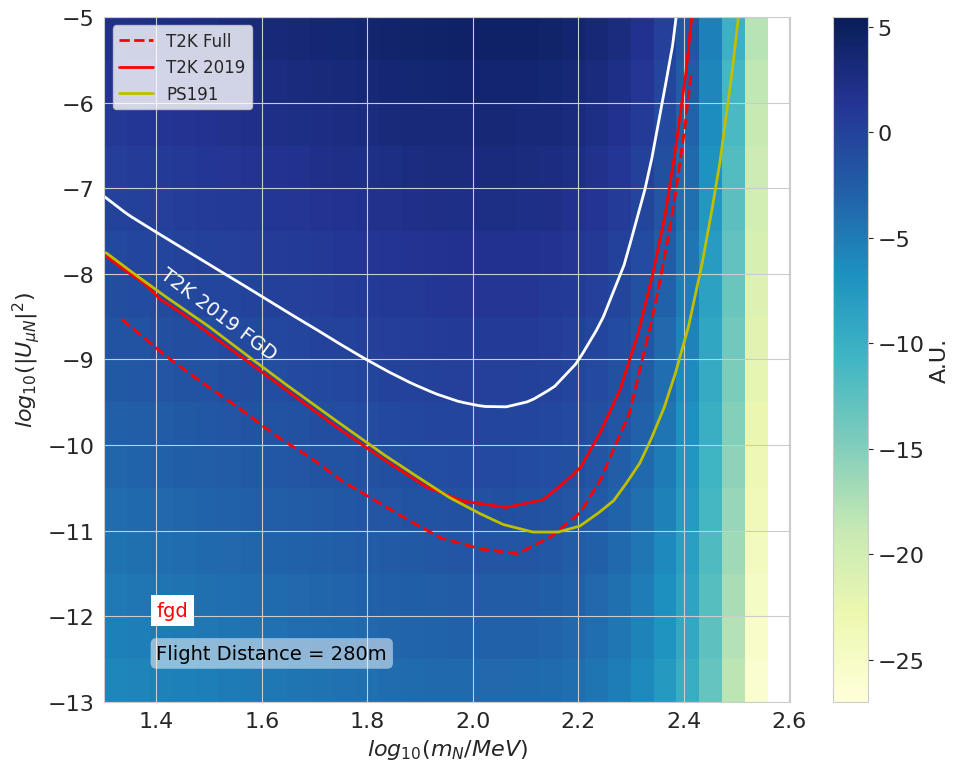

In [29]:
DIF_dist = 280

create_pixel_plot(np.log10(x*1000), np.log10(y**2), z, tar(cl=0.90), 
               scale='log', t2k_data=t2k_data, ps191_data=ps191_data, DIF_dist=DIF_dist, savestr=None, tag=tag)

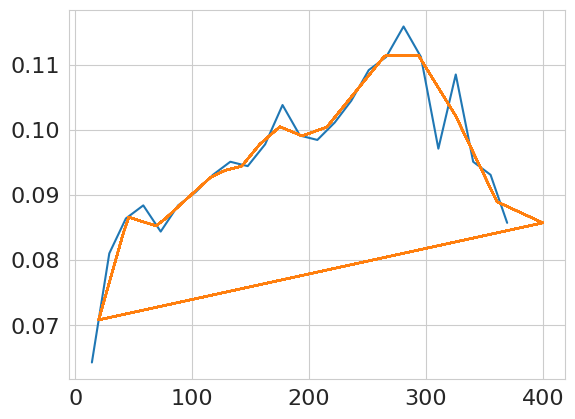

In [21]:
m_n, min_decay = np.loadtxt("kaon_decay_efficiency_data.txt", skiprows=0, usecols=(0, 1), unpack=True)
plt.plot(m_n,min_decay)
plt.plot(x*1000,min_efficiency)
plt.show()

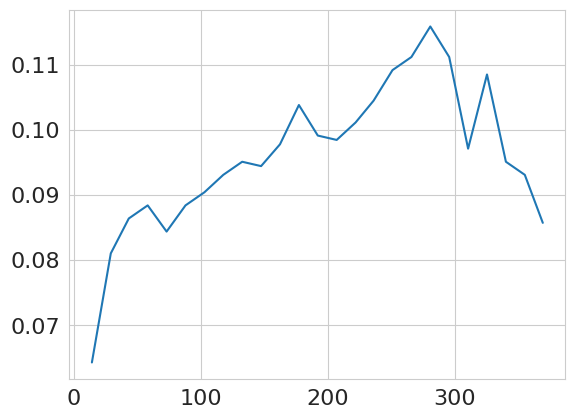

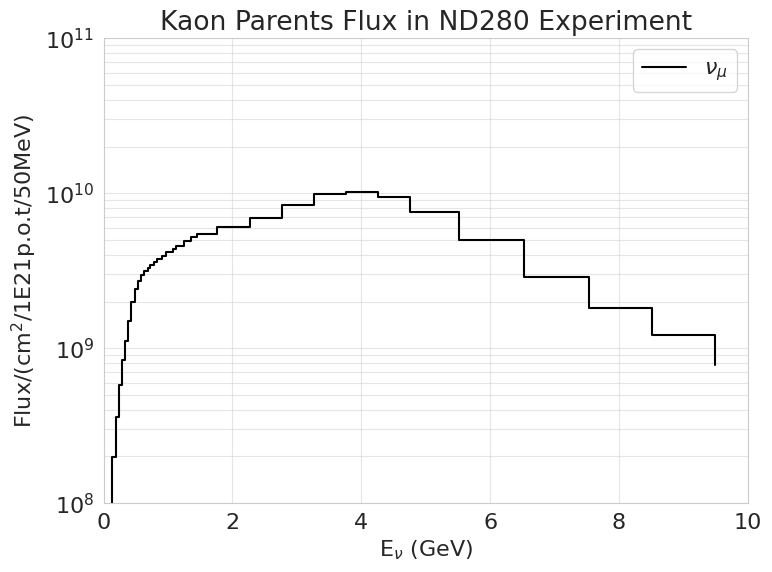

<Array [5.37e-54, 8.19e-157, ..., 6.75e-26, 3.95e-142] type='100000 * float64'>

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Read data from fil
energy = []
numu_flux = []
numubar_flux = []

with open('kaon-flux.dat','r') as f:
    for line in f.readlines():
        e, flux = line.strip().split()
        energy.append(float(e))
        numu_flux.append(10**float(flux))
        
# Convert to numpy arrays
energy = np.array(energy)
numu_flux = np.array(numu_flux)
# numubar_flux = np.array(numubar_flux)

# Create the plot
plt.figure(figsize=(8, 6))
plt.semilogy(energy, numu_flux, drawstyle='steps-post', label=r'$\nu_\mu$', color='black')
# plt.semilogy(energy, numubar_flux, drawstyle='steps-post', label='numubar', color='gray')

plt.xlabel('E$_\\nu$ (GeV)')
plt.ylabel('Flux/(cm$^2$/1E21p.o.t/50MeV)')
plt.title('Kaon Parents Flux in ND280 Experiment')
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.5)

plt.xlim(0, 10)
plt.ylim(1e8, 1e11)

plt.tight_layout()
plt.savefig('kaon_flux_plot.png', dpi=300)
plt.show()

In [9]:
sum = 0
with open('kaon-flux-data.dat','r') as r:
    for line in r.readlines()[3:]:
        a = line.strip().split()[4]
        sum += float(a)
        
print(a) 

6.50e+08


In [18]:
sum = 0
with open('kaon-flux.dat','r') as f:
    for line in f.readlines():
        _, a = line.strip().split()
        temp = 10**float(a)
        sum += temp
print(f'{sum:3.3e}')

1.350e+11


In [24]:
import numpy as np
import os
import siren
from siren.SIREN_Controller import SIREN_Controller
import multiprocessing as mp
from functools import partial

def generate_hnl_events(m, U, events_to_inject=100000, experiment="OGTPC1"):

    model_kwargs = {
        "m4": m,
        "mu_tr_mu4": 1e-6,
        "UD4": 0,
        "Umu4": U,
        "epsilon": 0.0,
        "gD": 0.0,
        "decay_product": "photon",
        "noHC": True,
        "HNLtype": "dirac",
    }

    controller = SIREN_Controller(events_to_inject, experiment)
    primary_type = siren.dataclasses.Particle.ParticleType.N4
    xs_path = siren.utilities.get_cross_section_model_path(f"DarkNewsTables-v{siren.utilities.darknews_version()}", must_exist=False)
    
    table_dir = os.path.join(xs_path, f"Dipole_M{m:.2e}_Umu{U:.2e}")
    controller.InputDarkNewsModel(primary_type, table_dir, **model_kwargs)

    flux_file = siren.utilities.get_tabulated_flux_file("N_Inject", "numu")
    mdist = siren.distributions.PrimaryMass(m)
    edist = siren.distributions.TabulatedFluxDistribution(flux_file, True)
    edist_gen = siren.distributions.TabulatedFluxDistribution(m * 1.01, 30, flux_file, False)

    direction_distribution = siren.distributions.FixedDirection(siren.math.Vector3D(0, 0, 1.0))

    position_distribution = siren.distributions.CylinderVolumePositionDistribution(siren.geometry.Cylinder(3.8,0,7.6))

    primary_injection_distributions = {
        "mass": mdist,
        "energy": edist_gen,
        "direction": direction_distribution,
        "position": position_distribution
    }
    primary_physical_distributions = {
        "mass": mdist,
        "energy": edist,
        "direction": direction_distribution
    }

    controller.SetProcesses(primary_type, primary_injection_distributions, primary_physical_distributions)
    controller.Initialize()

    print(f"Initialization complete for m={m:.2e}, U={U:.2e}")
    print(f"Minimum decay width: {controller.DN_min_decay_width}")

    events = controller.GenerateEvents(fill_tables_at_exit=False)
    
    os.makedirs("output", exist_ok=True)
    controller.SaveEvents(f"output/{experiment}_Dipole_M{m:.2e}_Umu{U:.2e}_example", fill_tables_at_exit=True)

    return f"Completed: m={m:.2e}, U={U:.2e}"

n_m, n_U = 30, 20
m_sample = np.geomspace(2e-2, 4e-1, n_m)
U_sample = np.geomspace(1e-7, 1e-2, n_U)
m_sample, U_sample = np.meshgrid(m_sample, U_sample)
m_sample = m_sample.flatten()
U_sample = U_sample.flatten()

indices = []

for m, U in zip(m_sample[indices],U_sample[indices]):
    generate_hnl_events(m, U)

In [5]:
def position_plot(x,y,bins,labelx,labely):
    plt.hist2d(x,y,bins=bins,norm=LogNorm())
    c = plt.colorbar()
    c.set_label("Number of Generated Events")
    plt.xlabel(labelx)
    plt.ylabel(labely)
    plt.tight_layout()
    

def plot_positions(data,range1,range2,slice1="x",slice2="y",kwags=None,binnum=100,pot=1E21):
    dec_flag = data["primary_type"]==5914
    fid_flag = data["in_fiducial"][dec_flag]
    weights = np.array(data['event_weight'])*pot
    
    fid_vertex = data["vertex"][data["in_fiducial"]][fid_flag]
    # mask out entries that are not fiducial
    fid_vertex = awk.mask(fid_vertex, awk.num(fid_vertex,axis=1)>0)
    fid_vertex = np.array(np.squeeze(fid_vertex[~awk.is_none(fid_vertex,axis=0)]))
    
    axis1 = {"x":0,"y":1,"z":2}[slice1]
    axis2 = {"x":0,"y":1,"z":2}[slice2]
    
    bins = (np.linspace(range1[0],range1[1],binnum),
            np.linspace(range2[0],range2[1],binnum))
    
    fig, ax = plt.subplots()
    

    position_plot(np.array(data["vertex"][dec_flag][:,0,axis1]),
        np.array(data["vertex"][dec_flag][:,0,axis2]),
        bins,"%s (m)"%slice1,"%s (m)"%slice2)

                
    plt.text( -4.5, -4.5, '$m=$%2.2e, $U_{\mu N}=$%2.2e'%(kwags['m'], kwags['U']), 
             color='black', fontsize=14, 
             bbox=dict(boxstyle="round",
                       alpha=0.7,
                       ec="black",
                       fc="white"))
    
    plt.show()

<>:34: SyntaxWarning: invalid escape sequence '\m'
<>:34: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_2839219/1611536255.py:34: SyntaxWarning: invalid escape sequence '\m'
  plt.text( -4.5, -4.5, '$m=$%2.2e, $U_{\mu N}=$%2.2e'%(kwags['m'], kwags['U']),


OGTPC1_Dipole_M2.73e-02_Umu1.00e-07_example.parquet


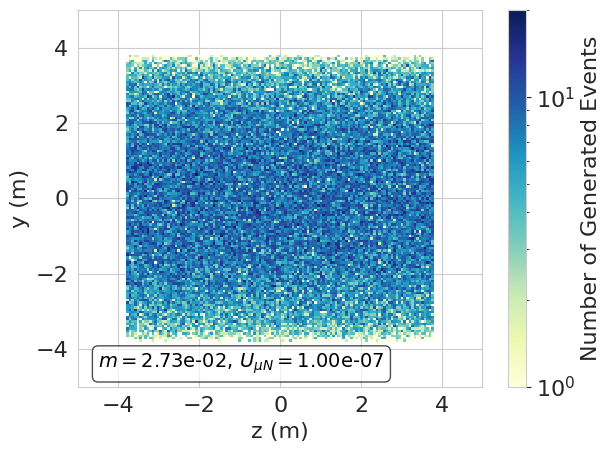

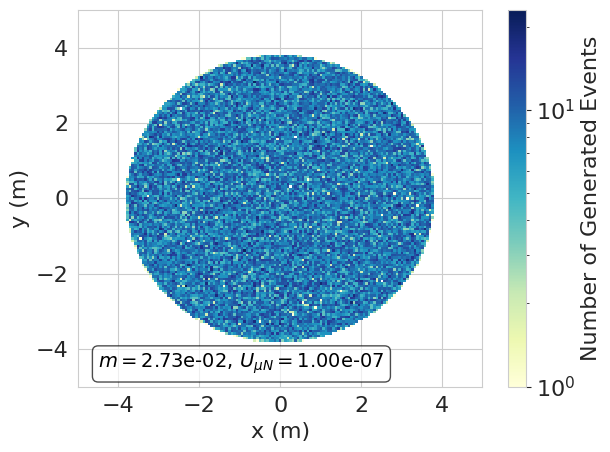

In [7]:
i = 3
kwags = {}
kwags['m'] = m_sample[i]
kwags['U'] = U_sample[i]
path=f"OGTPC1_Dipole_M{kwags['m']:.2e}_Umu{kwags['U']:.2e}_example.parquet"
if os.path.isfile('./output/'+path):
    print(path)
    data = awk.from_parquet("output/"+path)

Emax = 5
axis = 3
ylim_E = 1e6; ylim_C = 1e6
xrange = [-5,5]; yrange = [-5,5]; zrange = [-5,5]

plot_positions(data,zrange,yrange,"z","y",kwags=kwags,binnum=160,pot=POT['ND280_nu_2019'])
plot_positions(data,xrange,yrange,"x","y",kwags=kwags,binnum=160,pot=POT['ND280_nu_2019'])

In [4]:
import numpy as np
import os
import siren
from siren.SIREN_Controller import SIREN_Controller
import multiprocessing as mp
from functools import partial

def generate_hnl_events(m, U, events_to_inject=100000, experiment="OGTPC1"):
    
    path="OGTPC1_Dipole_M%2.2e_Umu%2.2e_example.parquet"%(m,U)
    
    if os.path.isfile(f"output/{path}"): 
        return f"File {path} already exists"
    
    model_kwargs = {
        "m4": m,
        "mu_tr_mu4": 1e-6,
        "UD4": 0,
        "Umu4": U,
        "epsilon": 0.0,
        "gD": 0.0,
        "decay_product": "photon",
        "noHC": True,
        "HNLtype": "dirac",
    }

    controller = SIREN_Controller(events_to_inject, experiment)
    primary_type = siren.dataclasses.Particle.ParticleType.N4
    xs_path = siren.utilities.get_cross_section_model_path(f"DarkNewsTables-v{siren.utilities.darknews_version()}", must_exist=False)
    
    table_dir = os.path.join(xs_path, f"Dipole_M{m:.2e}_Umu{U:.2e}")
    controller.InputDarkNewsModel(primary_type, table_dir, **model_kwargs)

    flux_file = siren.utilities.get_tabulated_flux_file("N_Inject", "numu")
    mdist = siren.distributions.PrimaryMass(m)
    edist = siren.distributions.TabulatedFluxDistribution(flux_file, True)
    edist_gen = siren.distributions.TabulatedFluxDistribution(m * 1.01, 30, flux_file, False)

    direction_distribution = siren.distributions.FixedDirection(siren.math.Vector3D(0, 0, 1.0))
    
    # decay_range_func = siren.distributions.DecayRangeFunction(m, controller.DN_min_decay_width, 3, 284.9)
    # position_distribution = siren.distributions.RangePositionDistribution(3.8, 3.8, decay_range_func, set(controller.GetDetectorModelTargets()[0]))

    position_distribution = siren.distributions.CylinderVolumePositionDistribution(siren.geometry.Cylinder(3.8,0,7.6))

    primary_injection_distributions = {
        "mass": mdist,
        "energy": edist_gen,
        "direction": direction_distribution,
        "position": position_distribution
    }
    primary_physical_distributions = {
        "mass": mdist,
        "energy": edist,
        "direction": direction_distribution
    }

    controller.SetProcesses(primary_type, primary_injection_distributions, primary_physical_distributions)
    controller.Initialize()

    print(f"Initialization complete for m={m:.2e}, U={U:.2e}")
    print(f"Minimum decay width: {controller.DN_min_decay_width}")

    events = controller.GenerateEvents(fill_tables_at_exit=False)
    
    os.makedirs("output", exist_ok=True)
    controller.SaveEvents(f"output/{experiment}_Dipole_M{m:.2e}_Umu{U:.2e}_example", fill_tables_at_exit=True)

    return f"Completed: m={m:.2e}, U={U:.2e}"

def main():
    n_m, n_U = 30, 20
    m_sample = np.geomspace(2e-2, 4e-1, n_m)
    U_sample = np.geomspace(1e-7, 1e-2, n_U)
    m_sample, U_sample = np.meshgrid(m_sample, U_sample)
    m_sample = m_sample.flatten()
    U_sample = U_sample.flatten()
    # # Determine the number of CPU cores to use
    # num_cores = mp.cpu_count() - 1  # Leave one core free
    # print(f"Using {num_cores} CPU cores for parallel processing")

    # # Create a pool of worker processes
    # with mp.Pool(num_cores) as pool:
    #     # Use starmap to pass multiple arguments to the function
    #     results = pool.starmap(generate_hnl_events, zip(m_sample, U_sample))
    
    # for result in results:
    #     print(result)
    
    ind = 11
    
    generate_hnl_events(m_sample[ind],U_sample[ind])

main()

Initializing the three-portal model.
Directory '/n/holylfs05/LABS/arguelles_delgado_lab/Everyone/msliu/siren_dn/lib/python3.12/site-packages/siren/resources/CrossSections/DarkNewsTables/2024_10_08__15:00' created successfully
Directory '/n/holylfs05/LABS/arguelles_delgado_lab/Everyone/msliu/siren_dn/lib/python3.12/site-packages/siren/resources/CrossSections/DarkNewsTables/2024_10_08__15:00/CrossSection_H1_p-el_nu(mu)_N4_flipping_/' created successfully
Directory '/n/holylfs05/LABS/arguelles_delgado_lab/Everyone/msliu/siren_dn/lib/python3.12/site-packages/siren/resources/CrossSections/DarkNewsTables/2024_10_08__15:00/CrossSection_He4_coherent_nu(mu)_N4_flipping_/' created successfully
Directory '/n/holylfs05/LABS/arguelles_delgado_lab/Everyone/msliu/siren_dn/lib/python3.12/site-packages/siren/resources/CrossSections/DarkNewsTables/2024_10_08__15:00/CrossSection_He4_p-el_nu(mu)_N4_flipping_/' created successfully
Directory '/n/holylfs05/LABS/arguelles_delgado_lab/Everyone/msliu/siren_dn/